### Setup

In [ ]:
# install if not yet done
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

In [ ]:
using Dragoon
using Plots, Plots.Measures
using Dates
using HDF5, DataFrames

include("analysis/tools/tools.jl");

In [ ]:
@load "full_20_24.0.jld2"

In [ ]:
n = 20 # number of discs in the booster

f = 20

freqs = genFreqs(f*1e9+25e6,50e6; n=10) # optimize on these frequencies
freqsplot = genFreqs(f*1e9+25e6,150e6; n=1000) # plot with these frequencies

booster = AnalyticalBooster(P0[f])  # physical properties of the booster

obj = ObjAnalytical

hist = initHist(booster,2*(booster.ndisk^2),freqs,obj);

In [ ]:
p0 = copy(booster.pos)

plot(freqsplot/1e9,getBoost1d(booster,freqsplot))

In [ ]:
move(booster,P0[10]; additive=false)

t1 = copy(booster.timestamp)
O1,P1,F1,s1,s_1 = dragoon(booster,hist,50e6,5e6,
        obj,UnstuckExpand(2,6_000);
        fmin=10e9,fmax=30e9,nfreqs=10,
        scalerange=(1.0,1.3),scalesteps=1000,
        preoptimize=false,reverse=false)

t2 = copy(booster.timestamp)
println("Elapsed movement time: ",canonicalize(t2-t1))

f1 = [(f[1]+f[end])/2 for f in F1];

In [ ]:
move(booster,P0[20]; additive=false)

t1 = copy(booster.timestamp)
O2,P2,F2,s2,s_2 = dragoon(booster,hist,50e6,5e6,
        obj,UnstuckExpand(2,6_000);
        fmin=20e9,fmax=40.0e9,nfreqs=10,
        scalerange=(1.0,1.4),scalesteps=1000,
        preoptimize=false,reverse=false)

t2 = copy(booster.timestamp)
println("Elapsed movement time: ",canonicalize(t2-t1))

f2 = [(f[1]+f[end])/2 for f in F2];

In [ ]:
move(booster,P0[40]; additive=false)

t1 = copy(booster.timestamp)
O3,P3,F3,s3,s_3 = dragoon(booster,hist,50e6,5e6,
        obj,UnstuckExpand(2,6_000);
        fmin=40e9,fmax=60.0e9,nfreqs=10,
        scalerange=(1.3,1.4),scalesteps=1000,
        preoptimize=false,reverse=false)

t2 = copy(booster.timestamp)
println("Elapsed movement time: ",canonicalize(t2-t1))

f3 = [(f[1]+f[end])/2 for f in F3];

In [ ]:
p3 = plot(collect(10:1:100).+0.025,-O0/1e3,label="scratch",seriestype=:scatter,
    xlabel="Frequency [GHz]",ylabel="Objective Value × 10³",markersize=2)


plot!(p3,f1/1e9,-O1/1e3; label="rescaling 1",c=:blue,lw=2)
plot!(p3,f2/1e9,-O2/1e3; label="rescaling 2",c=:red,lw=2)
plot!(p3,f3/1e9,-O3/1e3; label="rescaling 3",c=:green,lw=2)

# savefig(p3,"match.svg")

p3

In [ ]:
display(plot(s_1))
display(plot(s_2))
display(plot(s_3))

In [ ]:
p1 = plot(; xlabel="Frequency [GHz]",ylabel="Boostfactor β² × 10³",#size=(4000,800),
    left_margin=[5mm 0mm],bottom_margin=[5mm 0mm])
# p2 = plot(; xlabel="Frequency [GHz]",ylabel="Boostfactor β² × 10³",size=(4000,800),
#     left_margin=[10mm 0mm],bottom_margin=[10mm 0mm])

for i in eachindex(P)
    bw = F[i][end]-F[i][1]
    f = collect(range(F[i][1]-bw,F[i][end]+bw,100))
    b = boost1d(pos2dist(P[i]),f)
    plot!(p1,f/1e9,b/1e3,label="")
end
xlims!(p1,(21-0.1,22+0.1))
ylims!(p1,(0,25))

plot!(p1,f0/1e9,-O/1e3; c=:red,lw=1,label="minimum boost")

# savefig(p1,"coverage.svg")

p1


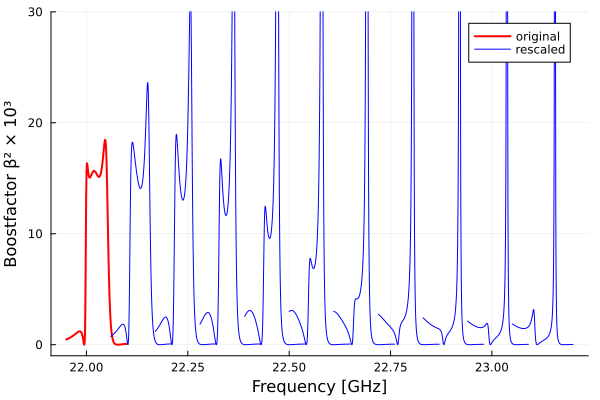

In [97]:
move(booster,P0[22]; additive=false)
fp = genFreqs(22.025e9,150e6; n=1000)

p5 = plot(fp/1e9,getBoost1d(booster,fp)/1e3;
    xlabel="Frequency [GHz]",ylabel="Boostfactor β² × 10³",c=:red,label="original",lw=2,
    ylims=(-1,30))

scale = 22e9/(22e9+25e6)
p_ = copy(booster.pos)
dd = (scale-1)*pos2dist(p_; disk_thickness=booster.thickness)

for i in 10:10:100
    move(booster,dist2pos(pos2dist(p_)+dd*50*i/100); additive=false)
    
    fp = genFreqs(22.025e9+i*11e6,150e6; n=1000)
    plot!(p5,fp/1e9,getBoost1d(booster,fp)/1e3; c=:blue,label=(i == 20 ? "rescaled" : ""))
end

savefig(p5,"rescale.svg")

p5

In [ ]:
dd